In [5]:
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import coremltools
import cv2
%matplotlib notebook
import sys
print(sys.version)

2.7.16 (default, Mar  4 2019, 09:01:38) 
[GCC 4.2.1 Compatible Apple LLVM 10.0.0 (clang-1000.11.45.5)]


# Load the image and predic labels

In [1]:
# Load the image
# img_rgb = Image.open('../../../samples/person_matthieu.jpg')
img_rgb = Image.open('../../../samples/car.jpg')
img_y = img_rgb.convert('L')

# Load the model and it's specs
model = coremltools.models.MLModel('../../../models/DeepLab.mlmodel')
input_width = model.get_spec().description.input[0].type.imageType.width
input_height = model.get_spec().description.input[0].type.imageType.height

# Resize the image to fit model's input size
small_img = img_rgb.resize((input_width, input_height), Image.BILINEAR)

# Predict the classes
y = model.predict({"image": small_img}, usesCPUOnly=False)
small_pred = y['scores']

# Resize the prediction to input image size
pred = small_pred.resize((img_rgb.width, img_rgb.height), PIL.Image.NEAREST)

# Compute the mask
# List of labels
labels = ['Background','Plane','Bicycle','Bird','Boat','Bottle','Bus','Car','Cat','Chair','Cow','Diningtable','Dog','Horse','Motorbike','Person','Pottedplant','Sheep','Sofa','Train','Tvmonitor']
label2id = {'Background':0,'Plane':1,'Bicycle':2,'Bird':3,'Boat':4,'Bottle':5,'Bus':6,'Car':7,'Cat':8,'Chair':9,'Cow':10,'Diningtable':11,'Dog':12,'Horse':13,'Motorbike':14,'Person':15,'Pottedplant':16,'Sheep':17,'Sofa':18,'Train':19,'Tvmonitor':20}
mask = np.zeros((img_rgb.height, img_rgb.width), np.uint8)
mask[np.array(pred) == label2id['Car']*12] = 255

# print np.array(pred)

# Plot
f, ax = plt.subplots(1,4)
ax[0].imshow(img_rgb)
ax[1].imshow(img_y, cmap='gray')
ax[2].imshow(pred)
ax[3].imshow(mask)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
ax[3].set_axis_off()
plt.show()

NameError: name 'Image' is not defined

# Resize image and mask

<IPython.core.display.Javascript object>


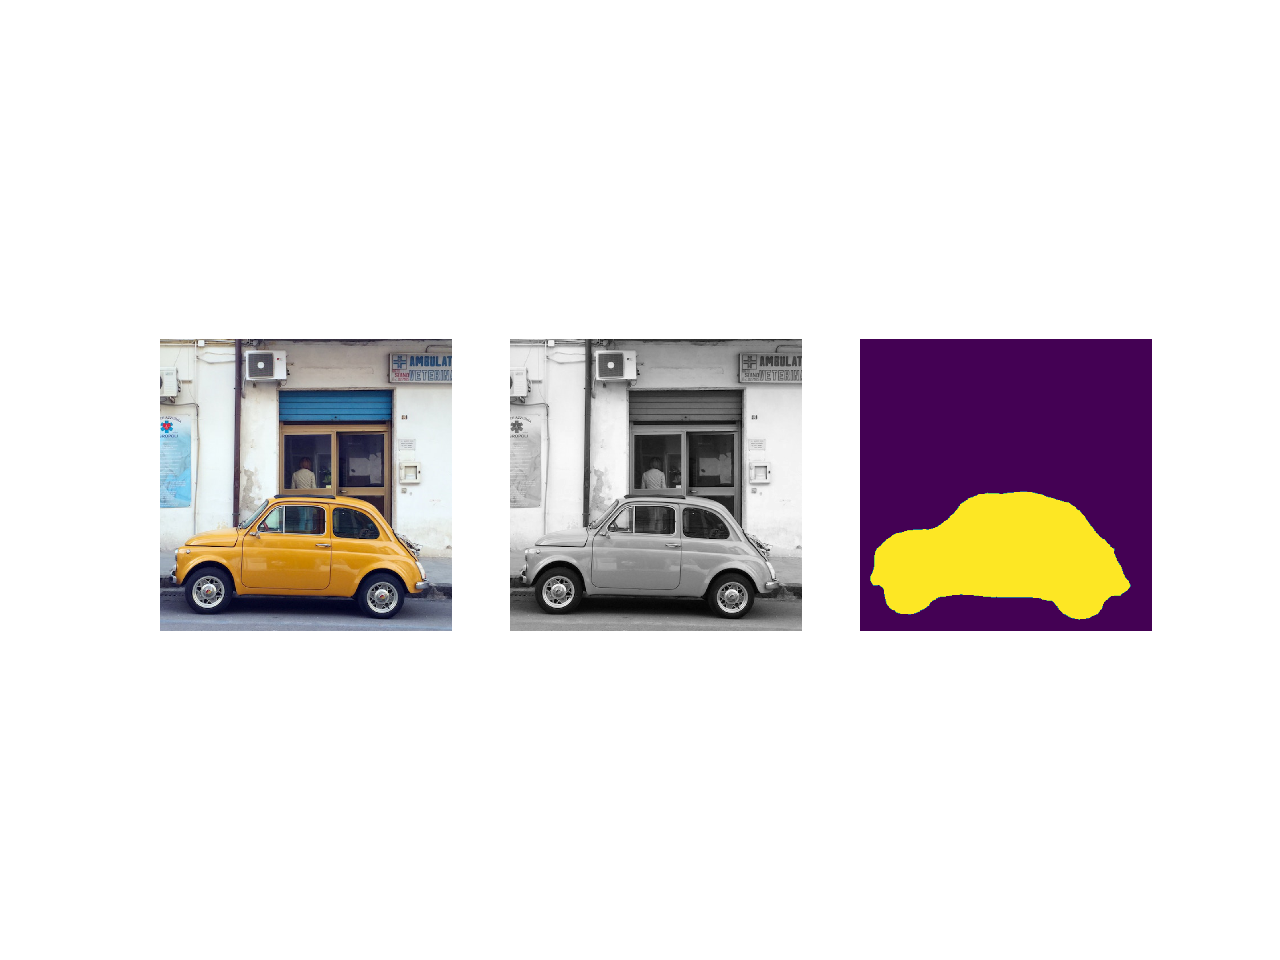

In [7]:
# Compute image size that fits in 1024x1024
max_size = 1024
if img_rgb.width >= img_rgb.height:
    width = max_size
    height = img_rgb.height * max_size / img_rgb.width
else:
    height = max_size
    width = img_rgb.width * max_size / img_rgb.height
    
# Resize all images
pil_rgb = img_rgb.resize((width, height), Image.BILINEAR)
pil_y = img_y.resize((width, height), Image.BILINEAR)
pil_mask = Image.fromarray(mask).resize((width, height), Image.BILINEAR)

# Convert images as numpy
np_rgb = np.array(pil_rgb)
np_y = np.array(pil_y)
np_mask = np.array(pil_mask)

# Plot
f, ax = plt.subplots(1,3)
ax[0].imshow(np_rgb)
ax[1].imshow(np_y, cmap='gray')
ax[2].imshow(np_mask)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.show()

# SLIC

In [8]:
import cv2
from time import time

# Initialize SLIC
region_size = int(min(np_y.shape) * 0.025)
sp = cv2.ximgproc.createSuperpixelSLIC(np_rgb, cv2.ximgproc.SLICO, region_size)

# Run the algorithm
tic = time()
sp.iterate(10)
toc = time()

# Display
print('Image size     : %d x %d' % (np_y.shape[0], np_y.shape[1]))
print('Region size    : %d' % region_size)
print('Nb SuperPixels : %d' % sp.getNumberOfSuperpixels())
print 'Elapsed time   : %f s' % (toc - tic)

Image size     : 1024 x 1024
Region size    : 25
Nb SuperPixels : 1661
Elapsed time   : 1.403576 s


<IPython.core.display.Javascript object>


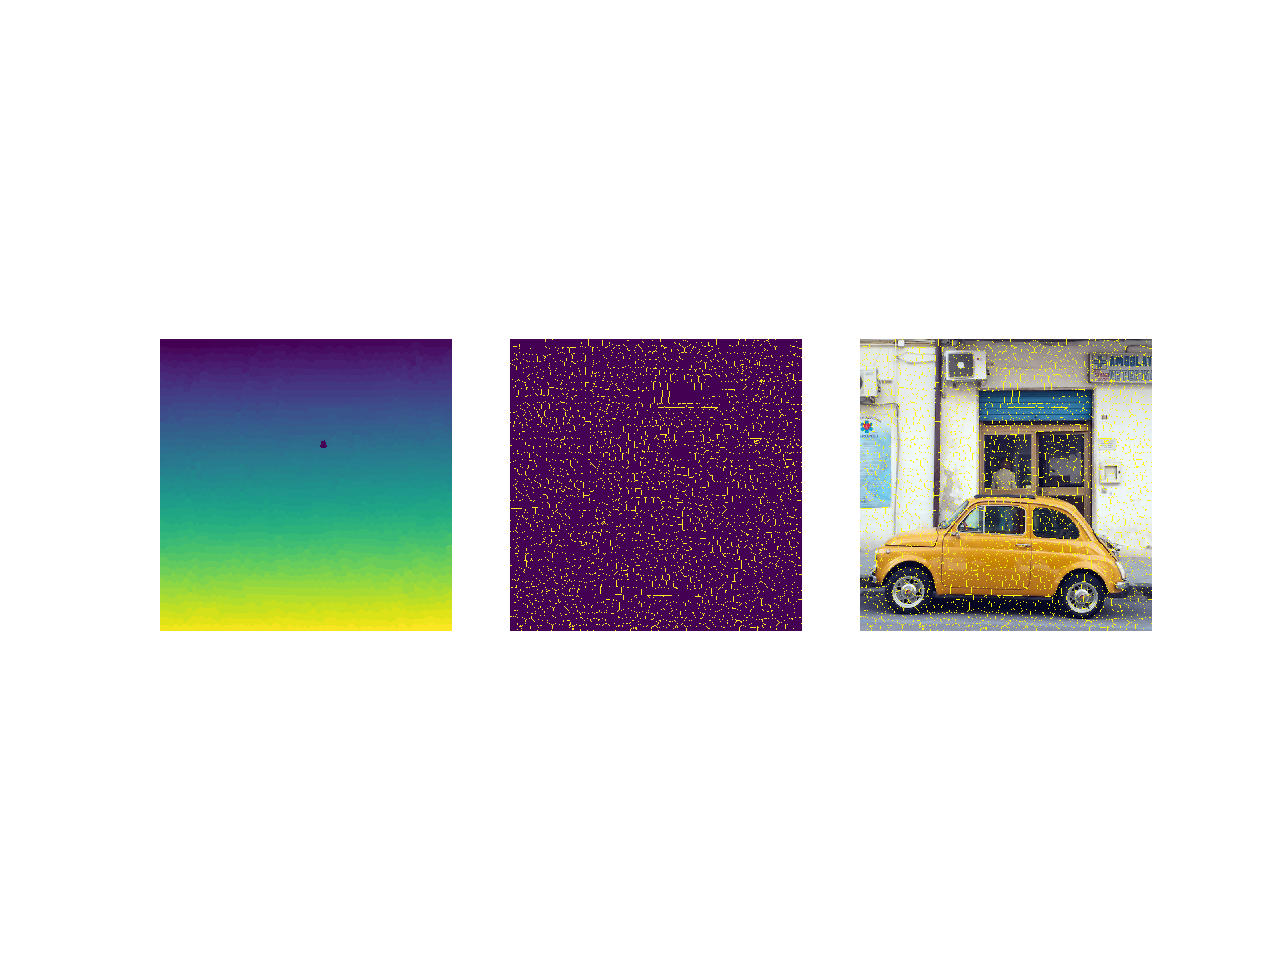

In [9]:
# Get the labels and the contours
labels = sp.getLabels()
contours = sp.getLabelContourMask(thick_line=True)

# Draw the contour over the initial image
img_with_ctr = np_rgb.copy()
img_with_ctr[:,:,0][contours > 0] = 255
img_with_ctr[:,:,1][contours > 0] = 255
img_with_ctr[:,:,2][contours > 0] = 0

# Plot
f, ax = plt.subplots(1,3)
ax[0].imshow(labels)
ax[1].imshow(contours)
ax[2].imshow(img_with_ctr)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.show()

# Deduce segmentation

<IPython.core.display.Javascript object>


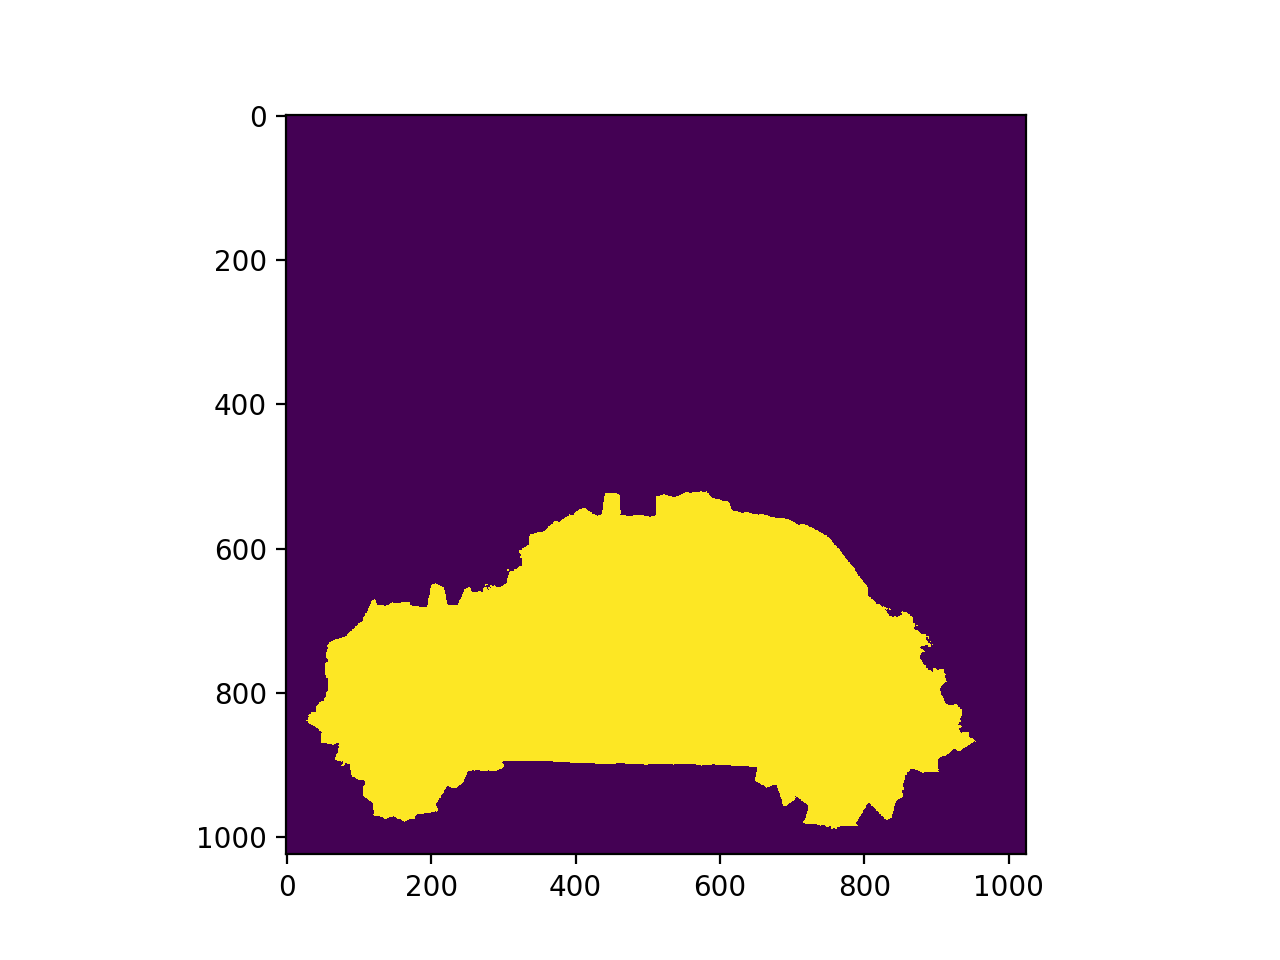

In [10]:
# Compute the segmentation
np_seg = np.zeros(np_mask.shape, np.uint8)
for i in range(sp.getNumberOfSuperpixels()):
    indices = labels == i
    mean = np.mean(np_mask[indices])
    np_seg[indices] = 0 if mean < 127 else 255
    
# Plot
plt.figure()
plt.imshow(np_seg)
plt.show()

<IPython.core.display.Javascript object>


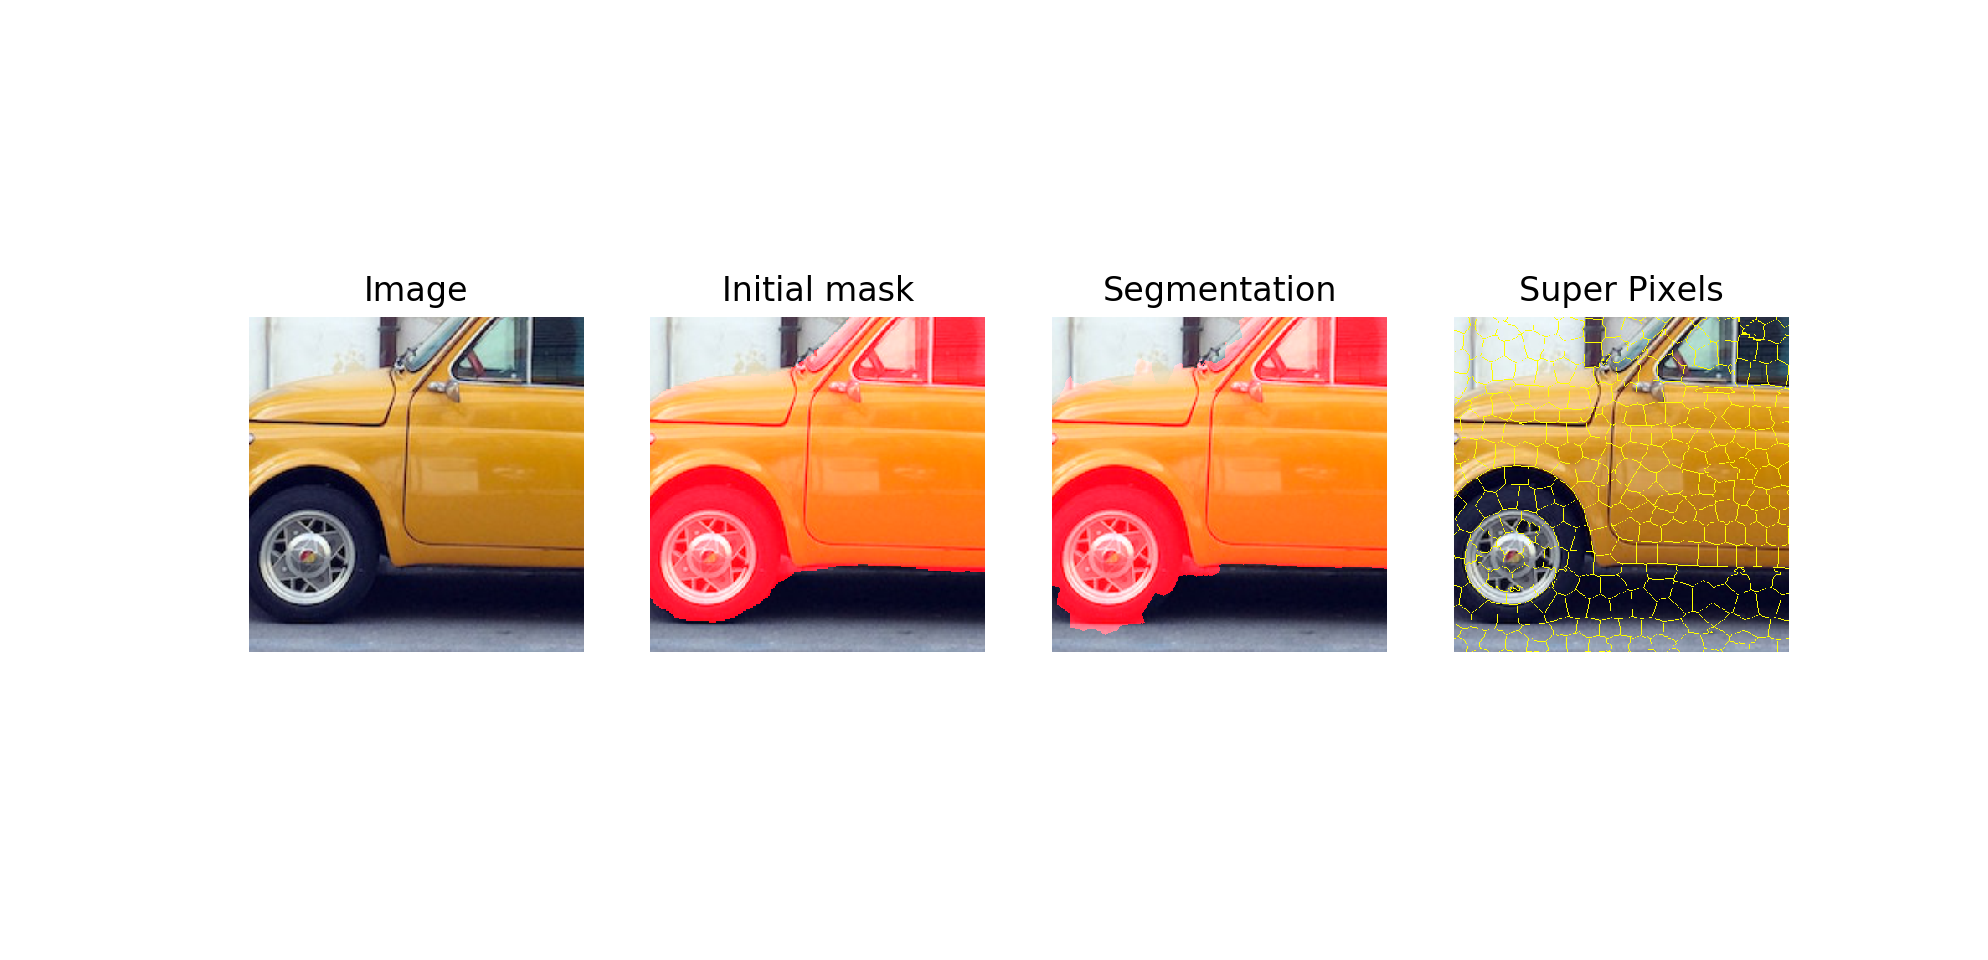

In [14]:
# Crop information
x = 100
y = 600
s = 400

# Overlay the initial mask over the picture
out_mask = np_rgb.copy()
out_mask[:,:,0][np_mask==255] = 255

# Overlay the final segmentation over the picture
out_sp = np_rgb.copy()
out_sp[:,:,0][np_seg==255] = 255

# Plot everything
f, ax = plt.subplots(1,4)
ax[0].imshow(np_rgb[y:y+s, x:x+s, :])
ax[1].imshow(out_mask[y:y+s, x:x+s, :])
ax[2].imshow(out_sp[y:y+s, x:x+s, :])
ax[3].imshow(img_with_ctr[y:y+s, x:x+s, :])
ax[0].set_title('Image')
ax[1].set_title('Initial mask')
ax[2].set_title('Segmentation')
ax[3].set_title('Super Pixels')
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
ax[3].set_axis_off()
plt.show()